In [975]:
import jax
import jax.numpy as jnp
import jax.experimental.mesh_utils as mesh_utils
import jax.numpy as jnp
import jax.random as jr
import jax.sharding as sharding

In [976]:
%%capture
!pip install equinox
!pip install easydict
!pip install jaxopt

In [977]:
import equinox as eqx
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import jaxopt

In [1356]:
import jax.numpy as jnp


# Function space
class UnitNormVec3RF:
    def __init__(self,  N=12, prngkey=None):
        if prngkey is not None:
            self.key = prngkey
        else:
            self.key = jax.random.PRNGKey(1701)
        self.N = N

        self.freqs = 2*jnp.pi*jnp.arange(-N*1.0, N+1.0, 1.0)
        self.fsize = 2*N+1

    def random(self, size):
        magnitudes = (jax.random.normal(self.key, (size, 2 * (self.fsize)**2)) +
                      1j*jax.random.normal(self.key, (size, 2 * (self.fsize)**2))) \
                      * 1/(2*self.fsize)**2

        return magnitudes

    def eval_batch(self, features, xs):
        x_tr = jnp.exp(1j*jnp.outer(xs[:,0], self.freqs))
        y_tr = jnp.exp(1j*jnp.outer(xs[:,1], self.freqs))

        f = jnp.reshape(features, (-1, self.freqs.size, self.freqs.size, 2))
        Z = jnp.einsum('abc,qb,qc->aq', f[...,0], x_tr, y_tr).real
        factor = jnp.sin(jnp.pi*xs[:,0])*jnp.sin(jnp.pi*xs[:,1])
        Z = (1.0-factor) + Z*factor
        normxy = jnp.sqrt(jnp.maximum(1.0-Z**2,0.0))
        XY = jnp.einsum('abc,qb,qc->aq', f[...,1], x_tr, y_tr)
        XY = jnp.exp(1j*2*jnp.pi*XY.imag)
        X = normxy * XY.real
        Y = normxy * XY.imag

        return jnp.stack([X,Y,Z],axis=1)


In [1357]:
space = UnitNormVec3RF(N=3)

In [1358]:
r = space.random(2)

In [1359]:
config = edict()
config.nmesh_size1d = 16
config.ntime = 200
config.maxtime = 100
config.btwidth = 1024
config.branchnet_layersizes = [3*config.nmesh_size1d**2, config.btwidth*3, config.btwidth*3]
config.trunknet_layersizes = [3, 1024, 1024, config.btwidth]
config.icweight = 1
config.bcweight = 1
config.normlossweight = 1
config.batchsize = 64
config.activation = jax.nn.relu
mkey = jax.random.PRNGKey(2031)
n = config.nmesh_size1d

In [1360]:


x = jnp.linspace(0,1,config.nmesh_size1d)
X, Y = jnp.meshgrid(x, x)
pts = jnp.stack([X.flatten(), Y.flatten()], axis=1)
example_u0 = space.eval_batch(r[0], pts)
example_u0 = jnp.reshape(example_u0, (3, n, n))

time_mesh = jnp.linspace(0, config.maxtime, config.ntime)

def pts_prod_time(xy, t):
    nt = len(t)
    nxy = len(xy)
    return jnp.hstack([jnp.tile(xy, (nt, 1)), (t[:,None]*jnp.ones((1,nxy))).reshape(nxy*nt, 1)])

spacetimepts = pts_prod_time(pts,time_mesh)

In [1250]:
spacetimepts

Array([[ 0.        ,  0.        ,  0.        ],
       [ 0.06666667,  0.        ,  0.        ],
       [ 0.13333334,  0.        ,  0.        ],
       ...,
       [ 0.86666673,  1.        , 20.        ],
       [ 0.9333334 ,  1.        , 20.        ],
       [ 1.        ,  1.        , 20.        ]], dtype=float32)

In [1361]:
bx0 = pts[jnp.where(pts[:,0]==0)[0]]
bx1 = pts[jnp.where(pts[:,0]==1)[0]]
by0 = pts[jnp.where(pts[:,1]==0)[0]]
by1 = pts[jnp.where(pts[:,1]==1)[0]]


bcx0=pts_prod_time(bx0,time_mesh)
bcx1=pts_prod_time(bx1,time_mesh)
bcy0=pts_prod_time(by0,time_mesh)
bcy1=pts_prod_time(by1,time_mesh)


bx0 = pts[jnp.where(pts[:,0]==0)[0]]
bx1 = pts[jnp.where(pts[:,0]==1)[0]]
by0 = pts[jnp.where(pts[:,1]==0)[0]]
by1 = pts[jnp.where(pts[:,1]==1)[0]]

In [1362]:
bcpts_where = jnp.where((pts[:,0]==0) | (pts[:,0]==1) | (pts[:,1]==1) | (pts[:,1]==0))
allbcpts = pts_prod_time(pts[bcpts_where], time_mesh)


In [986]:
class BranchNet(eqx.Module):
    # convlayers: list
    layers: list

    def __init__(self, key, configuration):
        lsz = configuration.branchnet_layersizes
        ktup = jax.random.split(key, num=len(lsz)+2)
        # convlayers = [eqx.nn.Conv(num_spatial_dims=2, in_channels=3, out_channels=6, kernel_size=3, padding=1, key=ktup[-1]),
        #           eqx.nn.Conv(num_spatial_dims=2, in_channels=6, out_channels=6, kernel_size=3, padding=1, key=ktup[-2]),
        #             eqx.nn.Conv(num_spatial_dims=2, in_channels=6, out_channels=6, kernel_size=5, padding=2, key=ktup[-3]),
        #          ]
        #for i in range(len(lsz)-1):
        #    layers.append(eqx.nn.Linear(lsz[i], lsz[i+1], key=ktup[i]))
        #self.convlayers = convlayers
        layers = []
        for i in range(len(lsz)-1):
            layers.append(eqx.nn.Linear(lsz[i], lsz[i+1], key=ktup[i]))
        self.layers = layers
    def __call__(self, x):
        x = jnp.ravel(x)
        # for layer in self.convlayers:
        #     x = config.activation(layer(x))
        #x = jnp.ravel(x)
        for layer in self.layers[:-1]:
            x = config.activation(layer(x))
        x = self.layers[-1](x)
        return jnp.reshape(x, (config.btwidth, 3))

        
        

In [987]:
class TrunkNet(eqx.Module):
    layers: list

    def __init__(self, key, configuration):
        lsz = configuration.trunknet_layersizes
        ktup = jax.random.split(key, num=len(lsz)-1)
        layers = []
        for i in range(len(lsz)-1):
            layers.append(eqx.nn.Linear(lsz[i], lsz[i+1], key=ktup[i]))
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = config.activation(layer(x))
        return self.layers[-1](x)

        

In [988]:
class DeepONet(eqx.Module):
    branch: BranchNet
    trunk: TrunkNet

    def __init__(self, key, configuration):
        key1, key2 = jax.random.split(key)
        self.branch = BranchNet(key1, configuration)
        self.trunk = TrunkNet(key2, configuration)
    def __call__(self, u, y):
        return jnp.sum(self.branch(u)*self.trunk(y)[...,None], axis=0)

In [989]:
example_u0.shape


(3, 16, 16)

In [990]:
dn = DeepONet(mkey, config)
dn(example_u0, jnp.array([0.1,0.1,0.1]))

Array([ 0.34078425, -0.29651982, -0.68439484], dtype=float32)

In [1363]:
def veclaplace(f, X):
    return jnp.sum(jax.jvp(jax.jacfwd(f), (X,), (jnp.array([1.0,1.0,0.0]),))[1], axis=-1)

def pdeloss(model, u0, ypt):
    cm = lambda y: model(u0, y)
    lapl = veclaplace(cm, ypt)
    sl = jnp.cross(model(u0,ypt), lapl)
    st = jax.jvp(lambda y: model(u0,y), (ypt,), (jnp.array([0.0,0.0,1.0]),))[1]
    return jnp.sum((st-sl)**2)

@jax.jit
def pdelosses(model, u0s, ypts):
    fn = jax.vmap(jax.vmap(pdeloss, (None, None, 0)), (None, 0, None))
    return 200*jnp.mean(fn(model, u0s, ypts))


icpts = jnp.hstack([pts, jnp.zeros((len(pts),1))])

@jax.jit
def icloss(model, u0):
    return config.icweight*jnp.mean((jax.vmap(model, (None, 0), out_axes=-1)(u0,icpts)-jnp.reshape(u0,(3,n*n)))**2)

@jax.jit
def icloss_tot(model, u0s):
    return jnp.mean(jax.vmap(icloss, (None, 0))(model, u0s))

@jax.jit
def bcloss_onebc(model, u0, bcpts1, bcpts2):
    bcvals1 = jax.vmap(model, (None, 0))(u0,bcpts1)
    bcvals2 = jax.vmap(model, (None, 0))(u0,bcpts2)
    return config.bcweight*jnp.mean((bcvals1-bcvals2)**2)
@jax.jit

def bcloss_onebc_dirichlet(model, u0, bcpt1, ideal):
    bcval1 = model(u0,bcpt1)
    return config.bcweight*jnp.mean((bcval1-ideal)**2)

@jax.jit
def bcloss(model, u0s):
    bcloss_onebc_manyu = jax.vmap(bcloss_onebc, (None, 0, None, None))
    return jnp.mean(bcloss_onebc_manyu(model, u0s, bcx0, bcx1) + bcloss_onebc_manyu(model, u0s, bcy0, bcy1))

@jax.jit
def bcloss_dirichlet_many(model, u0s, bcpts, ideal):
    fn = jax.vmap(jax.vmap(bcloss_onebc_dirichlet, (None, None, 0, None)), (None, 0, None, None))
    return jnp.mean(fn(model, u0s, bcpts, ideal))

@jax.jit
def bcloss_dirichlet_tot(model, u0s):
    ideal = jnp.array([0.0,0.0,1.0])
    return bcloss_dirichlet_many(model, u0s, allbcpts, ideal)

def normloss(model, u0, ypt):
    nrm = model(u0, ypt)
    return config.normlossweight*jnp.abs(jnp.sum(nrm**2,axis=-1) - 1.0) / (config.nmesh_size1d**2)



def norm_and_pde_loss(model, u0, ypt):
    return normloss(model, u0, ypt) + pdeloss(model, u0, ypt)

@jax.jit
def norm_and_pde_losses(model, u0s, ypts):
    fn = jax.vmap(jax.vmap(norm_and_pde_loss, (None, None, 0)), (None, 0, None))
    return jnp.mean(fn(model, u0s, ypts))

@jax.jit
def loss(model, u0s):
    return pdelosses(model, u0s, spacetimepts) + \
            icloss_tot(model, u0s) + \
            bcloss_dirichlet_tot(model, u0s)

def print_losses(model, u0s, spacetimepts):
    print("total", loss(model, u0s))
    print("ic", icloss_tot(model, u0s))
    print("bc", bcloss_dirichlet_tot(model, u0s))
    print("pde", pdelosses(model, u0s, spacetimepts))

In [1409]:
space = UnitNormVec3RF(N=2)
r2 = space.random(32)

In [1437]:
u0s = space.eval_batch(r2, pts)
u0s = jnp.reshape(u0s, (u0s.shape[0], 3, n, n))


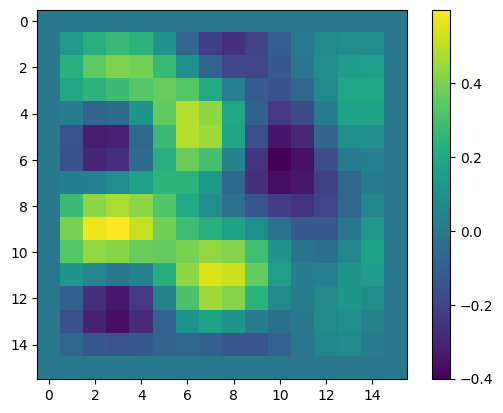

In [1438]:
example_u0 = u0s[0]
n = config.nmesh_size1d
example_u0 = jnp.reshape(example_u0, (3,n,n))
#example_u0 = jnp.moveaxis(example_u0, 2, 0)
plt.imshow(example_u0[1])
plt.colorbar()
plt.show()

In [1439]:
def dataloader(array, batch_size):
    dataset_size = array.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jax.random.permutation(mkey,indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield array[batch_perm]
            start = end
            end = start + batch_size

In [1440]:
print_losses(dn, u0s, spacetimepts)

total 0.033103056
ic 0.0061052623
bc 0.017233016
pde 0.009759959


In [1441]:
o = optax.adam(1e-6)
opt_state = o.init(dn)
tloss = loss

In [1442]:
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1))
shard = sharding.PositionalSharding(devices)

jg = jax.jit(jax.value_and_grad(tloss))


@jax.jit
def make_step(model, opt_state, u0slice):
    val, grads = jg(model, u0slice)
    updates, opt_state = o.update(grads, opt_state)
    model = optax.apply_updates(model, updates)
    return model, opt_state
    

In [1443]:
u0s_shard = jax.device_put(u0s, shard.reshape((num_devices,1,1,1)))

In [ ]:
jg = jax.jit(jax.value_and_grad(tloss))

@jax.jit
def jupdate(grads, opt_state):
    return o.update(grads, opt_state)
    
for i in range(20000):
    #print(f"iter {i}")
    val, grads = jg(dn, u0s)
    if i % 50 == 0:
        print(i, val)
    updates, opt_state = jupdate(grads, opt_state)
    dn = optax.apply_updates(dn, updates)

In [1445]:
print_losses(dn, u0s, spacetimepts)

total 0.011641277
ic 0.004955199
bc 0.0011838004
pde 0.0054968987


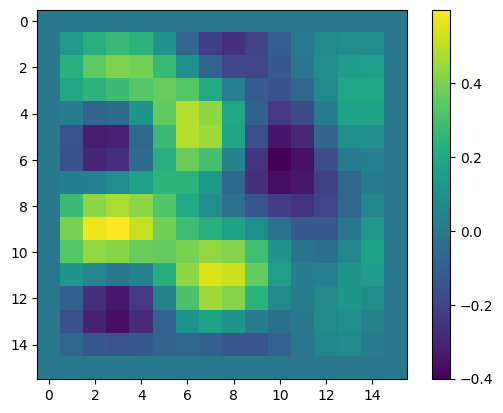

In [1446]:
n = config.nmesh_size1d
plt.imshow(u0s[0][1])
plt.colorbar()

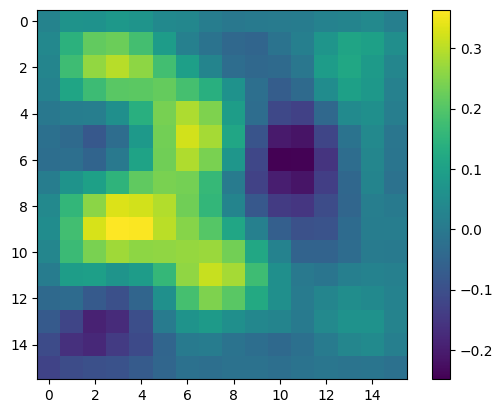

In [1447]:
eval=jax.vmap(dn, (None, 0))(u0s[0],jnp.hstack((pts,0*jnp.ones((n**2,1)))))
eval = jnp.moveaxis(eval.reshape((n,n,3)), 2, 0)
plt.imshow(eval[1])
plt.colorbar()

In [689]:
jnp.mean((eval[:-1]-u0s[3][:-1])**2)*config.icweight

Array(0.2364273, dtype=float32)

In [591]:
icloss(dn, u0s[3])

Array(0.01878591, dtype=float32)

In [1289]:
# import jaxopt

def okloss(params):
    return tloss(params, u0s_shard)



In [1290]:
opt = jaxopt.LBFGS(okloss, value_and_grad=False, jit=True, unroll=True, history_size=20)

In [1291]:
state = opt.init_state(dn)

In [1292]:
def jitted_update(params, state):
    return opt.update(params, state)

In [ ]:
for i in range(1000):
    # print(i)
    dn, state = jitted_update(dn, state)
    mloss = tloss(dn, u0s_shard)
    if i % 10 == 0:
        print(i, mloss)

In [1294]:
print_losses(dn, u0s, spacetimepts)

total 0.020946886
ic 0.005411828
bc 0.0007146722
pde 0.01948797


In [1383]:
eqx.tree_serialise_leaves("ok.eqx", dn)


In [1300]:
np=jnp
def topolar(x,y, ctr=(0,0)):
    r = np.sqrt((x-ctr[0])**2 + (y-ctr[1])**2)
    phi = np.arctan2(y-ctr[1], x-ctr[0])
    return r, phi

def fund_vortex(X, Y, a, v, scale=1.0, ctr=(0,0)):
    r, phi = topolar(X, Y, ctr=ctr)
    r_scale = r  / scale
    M1 = (2*v*a*r_scale)/(r_scale**2+a**2) * np.sin(phi)
    M2 = -(2*v*a*r_scale)/(r_scale**2+a**2) * np.cos(phi)
    M3 = (r_scale**2-a**2)/(r_scale**2+a**2)
    return np.stack([M1,M2,M3], axis=0)
    

In [1301]:

vtx = fund_vortex(X,Y, 0.1, 1, scale=1, ctr=(0.5,0.5))
fn=vtx

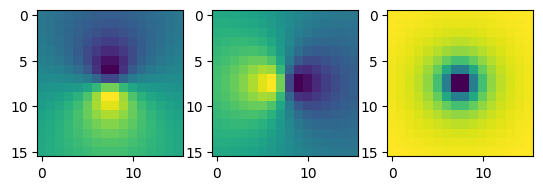

In [1422]:
fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(vtx[i])


In [1423]:
predmovie=jax.vmap(dn,(None,0))(fn,spacetimepts)

In [1502]:
dt=0.25
toplot = []
for t in jnp.arange(0,200,dt):
    grid = jnp.stack([X,Y,t*jnp.ones_like(X)],axis=-1).reshape(n*n,3)
    vals = jax.vmap(dn, (None, 0))(fn, grid)
    vals = jnp.moveaxis(vals.reshape(n,n,3), 2, 0)
    toplot.append(vals)

In [ ]:
ims = []
fig, ax = plt.subplots()
for arr in toplot:
        im = ax.imshow(jnp.reshape(arr,(3*n,n)), animated=True)
        ims.append([im])

from matplotlib import animation
ani1 = animation.ArtistAnimation(fig, ims, interval=30, blit=True,
                                repeat_delay=1000)
from IPython.display import HTML
HTML(ani1.to_html5_video())

In [ ]:
ani1.save("predicted_video2.mp4")

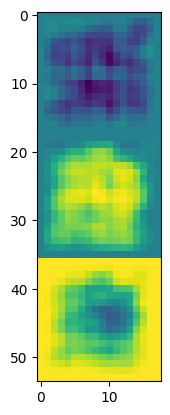

In [1488]:
from landaunet import geom
pd = geom.Periodic2D(n,n,0.025,2,data=u0s[0])

pd.setup_data()

ims = []
fig, ax = plt.subplots()
for k in range(8000):
    pd.step()
    if k % 10 == 0:
        im = ax.imshow(np.reshape(pd.data,(3*(n+2),(n+2))), animated=True)
        ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=30, blit=True,
                                repeat_delay=1000)
HTML(ani.to_html5_video())

In [1501]:
ani.save("true_video.mp4")